In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import nltk
import string
import matplotlib.pyplot as plt

In [3]:
from sklearn import neighbors
from sklearn.decomposition import TruncatedSVD

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sn

In [7]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

In [8]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [9]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score

In [10]:
con=sqlite3.connect('final_data.sqlite')

In [97]:
## We had cleansed and saved the final data for TSNE assignment. We use the same for this assignment.

review_data=pd.read_sql_query("""Select * from  Reviews_without_Stemming""",con)
print(review_data.shape)

(364171, 12)


In [98]:
review_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really ros...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud- nice rhythm well...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute littl...


In [99]:
## Filter out Non Food related reviews
review_data=review_data[review_data['ProductId'].str.startswith('B')]
print(review_data.shape)

(363967, 12)


## Data Sample and Time based splitting

In [100]:
## To avoid Out of Memory error, let's sample some rows and try on the sample data
sampled_data=review_data[['Time','Score','CleanedText']].sample(100000)

In [101]:
# Sort the data based on time for time based splitting.
sampled_data_sort=sampled_data.sort_values('Time')

In [102]:
# Check the data again
print(sampled_data_sort.head())
sampled_data_sort['Score'].value_counts()

          Time     Score                                        CleanedText
423  946857600  Positive  beetlejuice excellent funny movie  keaton hila...
308  948240000  Negative  i  always enjoyed movie  very funny entertaini...
241  961718400  Positive  really good idea final product outstanding  us...
485  965001600  Positive  recently purchased woodstream corp 0610 gopher...
837  965779200  Positive  much easier use wilson paste colors  colors vi...


Positive    84267
Negative    15733
Name: Score, dtype: int64

In [103]:
#Create Train/Test Split of data (based on time, as we have sorted data already)

Train_data=sampled_data_sort.iloc[0:75000]
print("Train data dim :",Train_data.shape)

Test_data=sampled_data_sort.iloc[75000:]
print("Test data dim :",Test_data.shape)

Train data dim : (75000, 3)
Test data dim : (25000, 3)


In [104]:
Train_data.Score.value_counts()

Positive    63593
Negative    11407
Name: Score, dtype: int64

In [105]:
Y_train_Polarity=Train_data['Score'].values

In [106]:
from sklearn.naive_bayes import MultinomialNB

## Naive Bayes with BOW

In [107]:
Train_data['CleanedText'].head(5)

423    beetlejuice excellent funny movie  keaton hila...
308    i  always enjoyed movie  very funny entertaini...
241    really good idea final product outstanding  us...
485    recently purchased woodstream corp 0610 gopher...
837    much easier use wilson paste colors  colors vi...
Name: CleanedText, dtype: object

In [108]:
# Create BOW with Train data
count_vect=CountVectorizer()
vocab=count_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
Train_counts=count_vect.transform(Train_data['CleanedText'].values)
Train_counts.get_shape()

(75000, 62226)

In [109]:
type(Train_counts)

scipy.sparse.csr.csr_matrix

In [110]:
Test_counts=count_vect.transform(Test_data['CleanedText'].values)
Test_counts.get_shape()

(25000, 62226)

######  Find Optimal Value of Laplace Smoothing Parameter -Alpha

In [111]:
alpha=[0.00001, 0.0001, 0.001, 0.01, 1, 10, 100]

In [112]:
cv_scores=[]
for value in alpha:
    NB_BOW=MultinomialNB(alpha=value)
    scores = cross_val_score(NB_BOW, Train_counts, Y_train_Polarity, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

misclassification_rate=[1-r for r in cv_scores]
# determining best alpha
optimal_alpha = alpha[misclassification_rate.index(min(misclassification_rate))]
print('\nThe optimal alpha is %f.' % optimal_alpha)


The optimal alpha is 1.000000.


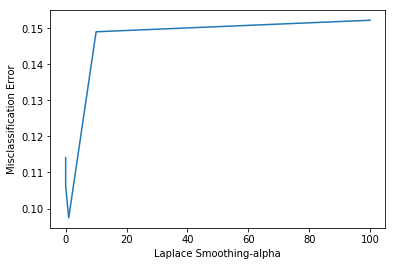

the misclassification error for each alpha value is :  [0.11412 0.11141 0.10904 0.10609 0.09739 0.14907 0.15227]


In [113]:
plt.plot(alpha, misclassification_rate)
x_val=np.arange(0,len(alpha))

plt.xlabel('Laplace Smoothing-alpha')
plt.ylabel('Misclassification Error')
#plt.xticks(x_val,alpha)
plt.show()

print("the misclassification error for each alpha value is : ", np.round(misclassification_rate,5))

######  Use Optimal Alpha to fit NB on BOW

In [114]:
NB_BOW=MultinomialNB(alpha=optimal_alpha)
NB_BOW.fit(Train_counts,Y_train_Polarity)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [115]:
test_predict=NB_BOW.predict(Test_counts)

In [116]:
test_predict[0:3]

array(['Positive', 'Positive', 'Negative'], dtype='<U8')

In [117]:
Test_acc = accuracy_score(Test_data['Score'].values, test_predict) * 100
print('\nThe accuracy of the knn classifier is %f%%' % (Test_acc))


The accuracy of the knn classifier is 90.384000%


We got a good accuracy with NB model. But Accuracy is not a good indicator of our model since our data is not well balanced. Hence, let's look at some other metrics to check our model

In [118]:
cm=confusion_matrix(Test_data['Score'].values, test_predict)

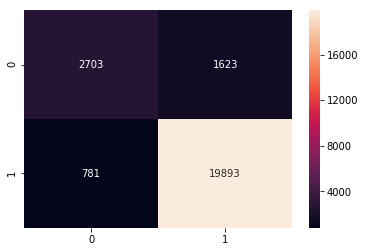

In [119]:
ax= plt.subplot()
sn.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [120]:
tn, fp, fn, tp = confusion_matrix(Test_data['Score'].values, test_predict).ravel()
print("True Negative :"+str(tn))
print("False Positive :"+str(fp))
print("False Negative :"+str(fn))
print("True positive :"+str(tp))

True Negative :2703
False Positive :1623
False Negative :781
True positive :19893


In [121]:
## Convert the string values of actual and prdicted test review into 1 for Positive and 0 for Negative

actual=np.array(Test_data['Score'].replace(['Positive','Negative'],[1,0]))
predicted=np.array(pd.Series(test_predict).replace(['Positive','Negative'],[1,0]))

In [122]:
## Lets check precision, recall abd F1 score
prec=precision_score(actual, predicted)
rec=recall_score(actual, predicted)
f1=f1_score(actual, predicted)

print("Precision :" +str(prec))
print("Recall :"+str(rec))
print("F1 Score :"+str(f1))

Precision :0.9245677635248187
Recall :0.9622230821321467
F1 Score :0.9430196729082722


###### Finding Top Features of the model

In [123]:
## Code snippet found on Stackoverflow
neg_class_prob_sorted = NB_BOW.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = NB_BOW.feature_log_prob_[1, :].argsort()

pos=pd.DataFrame(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:20]),pd.Series(pos_class_prob_sorted[:20]))
neg=pd.DataFrame(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:20]),pd.Series(neg_class_prob_sorted[:20]))


print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[::-1][:20]))
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[::-1][:20]))

['not' 'like' 'taste' 'product' 'one' 'would' 'very' 'it' 'good' 'flavor'
 'coffee' 'dont' 'tea' 'even' 'get' 'food' 'amazon' 'buy' 'much' 'really']
['not' 'like' 'good' 'great' 'very' 'one' 'taste' 'tea' 'flavor' 'love'
 'coffee' 'product' 'it' 'get' 'would' 'really' 'food' 'amazon' 'use'
 'best']


In [124]:
from wordcloud import WordCloud

###### Most imp positive words

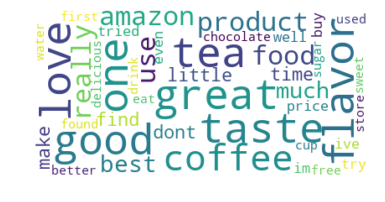

In [125]:
# Create and generate a word cloud image:
text_pos=pd.Series(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[::-1][:50]))
text_pos = " ".join(word for word in text_pos)

wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_pos)

# Display the generated image:
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

###### Most imp Negative words

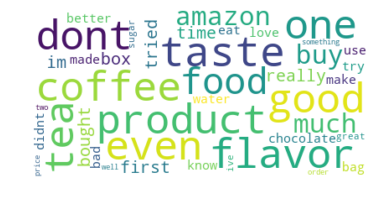

In [126]:
# Create and generate a word cloud image:
text_neg=pd.Series(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[::-1][:50]))
text_neg = " ".join(word for word in text_neg)

wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_neg)

# Display the generated image:
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

##  Check what words comprise the negative reviews

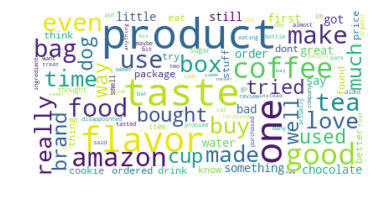

In [149]:
Neg_reviews = " ".join(sent for sent in Train_data[Train_data['Score']=='Negative']['CleanedText'].values)

wordcloud_neg_all = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(Neg_reviews)

# Display the generated image:
plt.imshow(wordcloud_neg_all, interpolation='bilinear')
plt.axis("off")
plt.show()

The top positive and negative words do not not indicate what words actually classify the psotive and negative reviews. Bigrams may be more useful than unigrams in our case

## Naive Bayes using TF-IDF

In [128]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [129]:
## Create a tf-idf vectorizer-unigram

## For Train data

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
tf_idf_vocab=tf_idf_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
tf_idf_train_counts=tf_idf_vect.transform(Train_data['CleanedText'].values)
tf_idf_train_counts.get_shape()

(75000, 62226)

In [130]:
## For Test Data
tf_idf_test_counts=tf_idf_vect.transform(Test_data['CleanedText'].values)
tf_idf_test_counts.get_shape()

(25000, 62226)

######  Find Optimal value of Laplace Smoothing parameter -Alpha

In [131]:
alpha=[0.00001, 0.0001, 0.001, 0.01, 1, 10, 100]

In [132]:
cv_scores_tfidf=[]
for value in alpha:
    NB_TFIDF=MultinomialNB(alpha=value)
    scores_tfidf = cross_val_score(NB_TFIDF, tf_idf_train_counts, Y_train_Polarity, cv=10, scoring='accuracy')
    cv_scores_tfidf.append(scores_tfidf.mean())

misclassification_rate_tfidf=[1-r for r in cv_scores_tfidf]
# determining best alpha
optimal_alpha_tfidf = alpha[misclassification_rate_tfidf.index(min(misclassification_rate_tfidf))]
print('\nThe optimal alpha is %f.' % optimal_alpha_tfidf)


The optimal alpha is 0.010000.


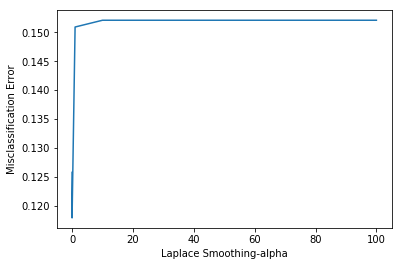

the misclassification error for each alpha value is :  [0.12575 0.12368 0.12075 0.11785 0.15092 0.15209 0.15209]


In [133]:
plt.plot(alpha, misclassification_rate_tfidf)
x_val=np.arange(0,len(alpha))

plt.xlabel('Laplace Smoothing-alpha')
plt.ylabel('Misclassification Error')
#plt.xticks(x_val,alpha)
plt.show()

print("the misclassification error for each alpha value is : ", np.round(misclassification_rate_tfidf,5))

###### Using Optimal Alpha to fit NB

In [134]:
NB_TFIDF=MultinomialNB(alpha=optimal_alpha_tfidf)
NB_TFIDF.fit(tf_idf_train_counts,Y_train_Polarity)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [135]:
test_predict_tfidf=NB_TFIDF.predict(tf_idf_test_counts)

In [136]:
test_predict_tfidf[0:3]

array(['Positive', 'Positive', 'Positive'], dtype='<U8')

In [137]:
Test_acc_tfidf = accuracy_score(Test_data['Score'].values, test_predict_tfidf) * 100
print('\nThe accuracy of the knn classifier is %f%%' % (Test_acc_tfidf))


The accuracy of the knn classifier is 86.748000%


The Accuracy is low compared to BOW Naive Bayes Model.

In [138]:
cm_tfidf=confusion_matrix(Test_data['Score'].values, test_predict_tfidf)

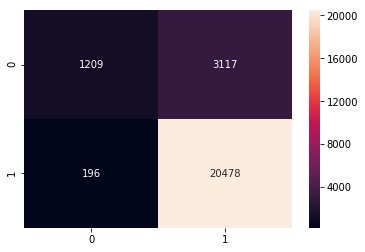

In [139]:
ax= plt.subplot()
sn.heatmap(cm_tfidf, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [140]:
tn, fp, fn, tp = confusion_matrix(Test_data['Score'].values, test_predict_tfidf).ravel()
print("True Negative :"+str(tn))
print("False Positive :"+str(fp))
print("False Negative :"+str(fn))
print("True positive :"+str(tp))

True Negative :1209
False Positive :3117
False Negative :196
True positive :20478


In [141]:
## Convert the string values of actual and prdicted test review into 1 for Positive and 0 for Negative

actual_tfidf=np.array(Test_data['Score'].replace(['Positive','Negative'],[1,0]))
predicted_tfidf=np.array(pd.Series(test_predict_tfidf).replace(['Positive','Negative'],[1,0]))

In [142]:
## Lets check precision, recall abd F1 score
prec=precision_score(actual_tfidf, predicted_tfidf)
rec=recall_score(actual_tfidf, predicted_tfidf)
f1=f1_score(actual_tfidf, predicted_tfidf)

print("Precision :" +str(prec))
print("Recall :"+str(rec))
print("F1 Score :"+str(f1))

Precision :0.8678957406230133
Recall :0.9905194930830995
F1 Score :0.9251620773001422


###### Finding Top Positive and Negative features (words)

In [143]:
## Code snippet found on Stackoverflow
neg_class_prob_sorted = NB_TFIDF.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = NB_TFIDF.feature_log_prob_[1, :].argsort()

pos=pd.DataFrame(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[:20]),pd.Series(pos_class_prob_sorted[:20]))
neg=pd.DataFrame(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[:20]),pd.Series(neg_class_prob_sorted[:20]))


print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[::-1][:20]))
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[::-1][:20]))

['not' 'like' 'taste' 'product' 'would' 'coffee' 'one' 'very' 'flavor'
 'it' 'dont' 'good' 'tea' 'buy' 'even' 'box' 'get' 'bad' 'much' 'again']
['great' 'good' 'not' 'like' 'tea' 'coffee' 'very' 'love' 'product'
 'taste' 'one' 'flavor' 'it' 'best' 'amazon' 'price' 'really' 'find' 'get'
 'use']


###### Top Positive Words

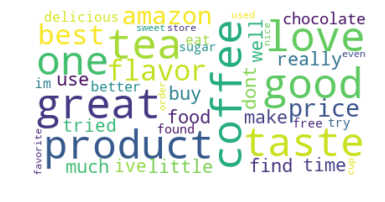

In [144]:
# Create and generate a word cloud image:
text_pos=pd.Series(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[::-1][:50]))
text_pos = " ".join(word for word in text_pos)

wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_pos)

# Display the generated image:
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

###### Top Negative Words

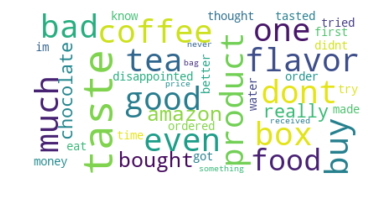

In [145]:
# Create and generate a word cloud image:
text_neg=pd.Series(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[::-1][:50]))
text_neg = " ".join(word for word in text_neg)

wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_neg)

# Display the generated image:
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

## Other Experiments

###### For BOW Model

In [146]:
## Find optimal alpha using F1 Score metric for BOW
Y_train_Polarity_converted=np.array(Train_data['Score'].replace(['Positive','Negative'],[1,0]))
cv_scores=[]
for value in alpha:
    NB_BOW=MultinomialNB(alpha=value)
    scores = cross_val_score(NB_BOW, Train_counts, Y_train_Polarity_converted, cv=10, scoring='f1')
    cv_scores.append(scores.mean())

misclassification_rate=[1-r for r in cv_scores]
# determining best alpha
optimal_alpha = alpha[misclassification_rate.index(min(misclassification_rate))]
print('\nThe optimal alpha using f1 score is %f.' % optimal_alpha)


The optimal alpha using f1 score is 1.000000.


* Optimal Alpha for BOW is same for both Accuracy and F1 Score metric

###### For TF-IDF Model

In [147]:
cv_scores_tfidf=[]
for value in alpha:
    NB_TFIDF=MultinomialNB(alpha=value)
    scores_tfidf = cross_val_score(NB_TFIDF, tf_idf_train_counts, Y_train_Polarity_converted, cv=10, scoring='f1')
    cv_scores_tfidf.append(scores_tfidf.mean())

misclassification_rate_tfidf=[1-r for r in cv_scores_tfidf]
# determining best alpha
optimal_alpha_tfidf = alpha[misclassification_rate_tfidf.index(min(misclassification_rate_tfidf))]
print('\nThe optimal alpha using f1 score is %f.' % optimal_alpha_tfidf)


The optimal alpha using f1 score is 0.010000.


* Optimal Alpha for TF-IDF is same for both Accuracy and F1 Score metric

## Conclusion

| Model | Alpha | Acc | TN | FP | FN | TP | Precision | Recall | F1 |
|-------|-----|----|----|-----|----|-----|---|----|----|
| BOW |1.0 |90.38%| 2703|1623 | 781| 19823| 0.92|0.96 | 0.94|
| TF-IDF | 0.01|86.74% |1209| 3117|196|20478 |0.87 | 0.99 | 0.93 |

* From the table it seems that Naive Bayes with BOW is a better model to use